# **Modelos Econométricos**
Neste notebook tem os seguintes modelos estatísticos:
- AR
- ARIMA
- SARIMA

## **1. Prepare Environment**

<br/>


### Imports

In [47]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# statsmodels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm

# autoarima
import pmdarima as pm

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import itertools
import os

<br/>

### Set Config

In [2]:
%matplotlib inline

# Carrega a extensão "autoreload" para que o código possa mudar
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set_context("paper")  # Definindo o contexto para "paper"
sns.set_theme(style='darkgrid',
    palette='deep',
    color_codes=True,
    rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Suprima avisos desnecessários para que a apresentação pareça limpa
warnings.filterwarnings('ignore')

In [3]:
# plt.style.use('seaborn')  # fivethirtyeight - Removido
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set_theme(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set_theme(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [4]:
%%time

df_soja = pd.read_csv(r'C:\Users\Lucas S\OneDrive\Documents\ADM_UFPB\TCC1\db_soja_modificado\db_pré_processado_dolar.csv',
                              encoding='utf8',
                              delimiter=',',
                              parse_dates=True,
                              index_col=0,
                              verbose=True)

Tokenization took: 25.16 ms
Type conversion took: 14.95 ms
Parser memory cleanup took: 0.00 ms
CPU times: total: 31.2 ms
Wall time: 694 ms


In [5]:
df_soja.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2006-04-17,12.77,-0.04,12.77,-0.01,0.06,0.11,0.17,0.23,0.23
2006-04-18,12.88,-0.09,12.79,-0.01,0.11,0.17,0.22,0.28,0.34
2006-04-19,12.82,-0.26,12.82,-0.01,-0.06,0.05,0.11,0.16,0.22
2006-04-20,12.75,-0.25,12.85,-0.04,-0.07,-0.13,-0.02,0.04,0.09
2006-04-21,12.80,-0.13,12.88,-0.04,0.05,-0.02,-0.08,0.03,0.09


---

## **2. Split Data**

In [6]:
# Definir a série temporal
ts = df_soja['preco']

# Dividir os dados em treinamento e teste
size_train = int(len(ts) * 0.8)
df_train, df_test = ts[0:size_train], ts[size_train:len(ts)]
size_test = len(df_test)

print('Observations: %d' % (len(ts)))
print('Training Observations: %d' % (len(df_train)))
print('Testing Observations: %d' % (len(df_test)))

Observations: 6450
Training Observations: 5160
Testing Observations: 1290


In [7]:
df_train.tail()

data
2020-05-28   19.84
2020-05-29   20.13
2020-05-30   20.10
2020-05-31   20.07
2020-06-01   20.04
Name: preco, dtype: float64

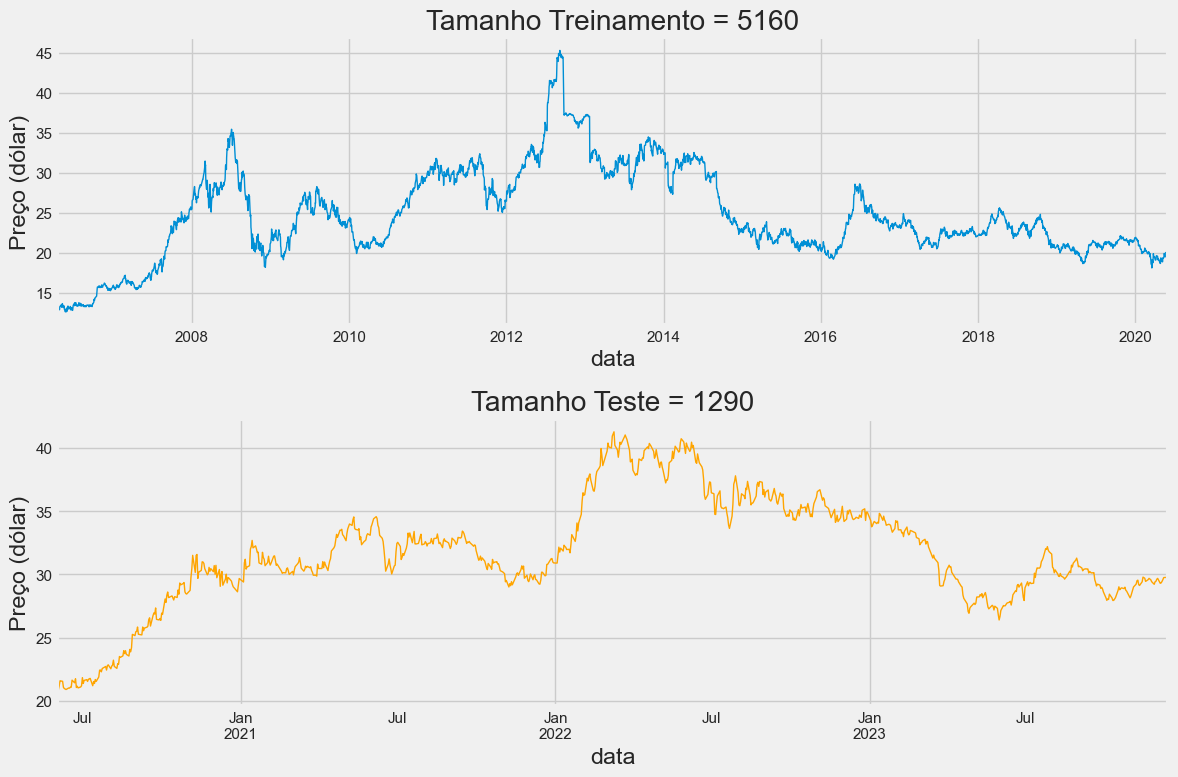

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot train
ax1 = df_train.plot(kind='line', linewidth=1, ax=ax1, grid=True, title=f'Tamanho Treinamento = {len(df_train)}')
ax1.set_ylabel("Preço (dólar)")

# Plot test
ax2 = df_test.plot(kind='line', linewidth=1, ax=ax2, grid=True, title=f'Tamanho Teste = {len(df_test)}', color='orange')
ax2.set_ylabel("Preço (dólar)")

plt.show()

### Manipulação do índice

In [13]:
df_train.index

DatetimeIndex(['2006-04-17', '2006-04-18', '2006-04-19', '2006-04-20',
               '2006-04-21', '2006-04-22', '2006-04-23', '2006-04-24',
               '2006-04-25', '2006-04-26',
               ...
               '2020-05-23', '2020-05-24', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28', '2020-05-29', '2020-05-30',
               '2020-05-31', '2020-06-01'],
              dtype='datetime64[ns]', name='data', length=5160, freq=None)

In [14]:
df_test.index

DatetimeIndex(['2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11',
               ...
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-09', '2023-12-10', '2023-12-11',
               '2023-12-12', '2023-12-13'],
              dtype='datetime64[ns]', name='data', length=1290, freq=None)

In [15]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=5160, step=1)

In [16]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=1290, step=1)

In [17]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=5160, step=1)

In [18]:
df_test.index = pd.RangeIndex(start=len(df_train), stop=len(df_train) + len(df_test), step=1)
df_test.index

RangeIndex(start=5160, stop=6450, step=1)

---

## **3. Avaliação**

In [19]:
dict_results = {}

<br/>

### Exibir resultados

In [50]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    #mape = mean_absolute_percentage_error(df_test, y_forecast)
    mape = mean_absolute_percentage_error(df_test, y_forecast)*100
    
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

<br/>

### Busca dos Melhores Parâmetros

#### Grid Search

In [22]:
# Defina os parâmetros p, d e q para assumir qualquer valor entre 0 e 2
p = q = range(0, 3)
d = range(0, 3)

# Gere todas as combinações diferentes de trigêmeos p, q e q
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Gere todas as diferentes combinações de trigêmeos p, q e q sazonais
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [23]:
def search_best_params_arima_model(df_train: pd.DataFrame, pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()
    
    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')
            
            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except: 
            continue
    
    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [24]:
def search_best_params_sarima_model(df_train, trend, pdq):  
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()
    
    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,          
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except: 
            continue
    
    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

---

## **4. Modeling**

<br/>

### **Build Model**

#### **Modelos Estatísticos**

#### **AR**

In [33]:
# Calcule o número de defasagens como a raiz quadrada do número de observações em df_train
lags = int(np.sqrt(len(df_train)))

In [34]:
ar_model = AutoReg(df_train,
                   lags=lags,
                   trend='c',
                   seasonal=True,
                   period=len(df_test))
ar_fit = ar_model.fit()

In [74]:
print(ar_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  preco   No. Observations:                 5160
Model:              Seas. AutoReg(71)   Log Likelihood                  32.882
Method:               Conditional MLE   S.D. of innovations              0.240
Date:                Tue, 26 Mar 2024   AIC                           2658.236
Time:                        17:28:11   BIC                          11558.683
Sample:                            71   HQIC                          5774.917
                                 5160                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1542      0.141     -1.094      0.274      -0.431       0.122
s(2,1290)        0.3491      0.198      1.763      0.078      -0.039       0.737
s(3,1290)        0.2128      0.198      1.07

In [75]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

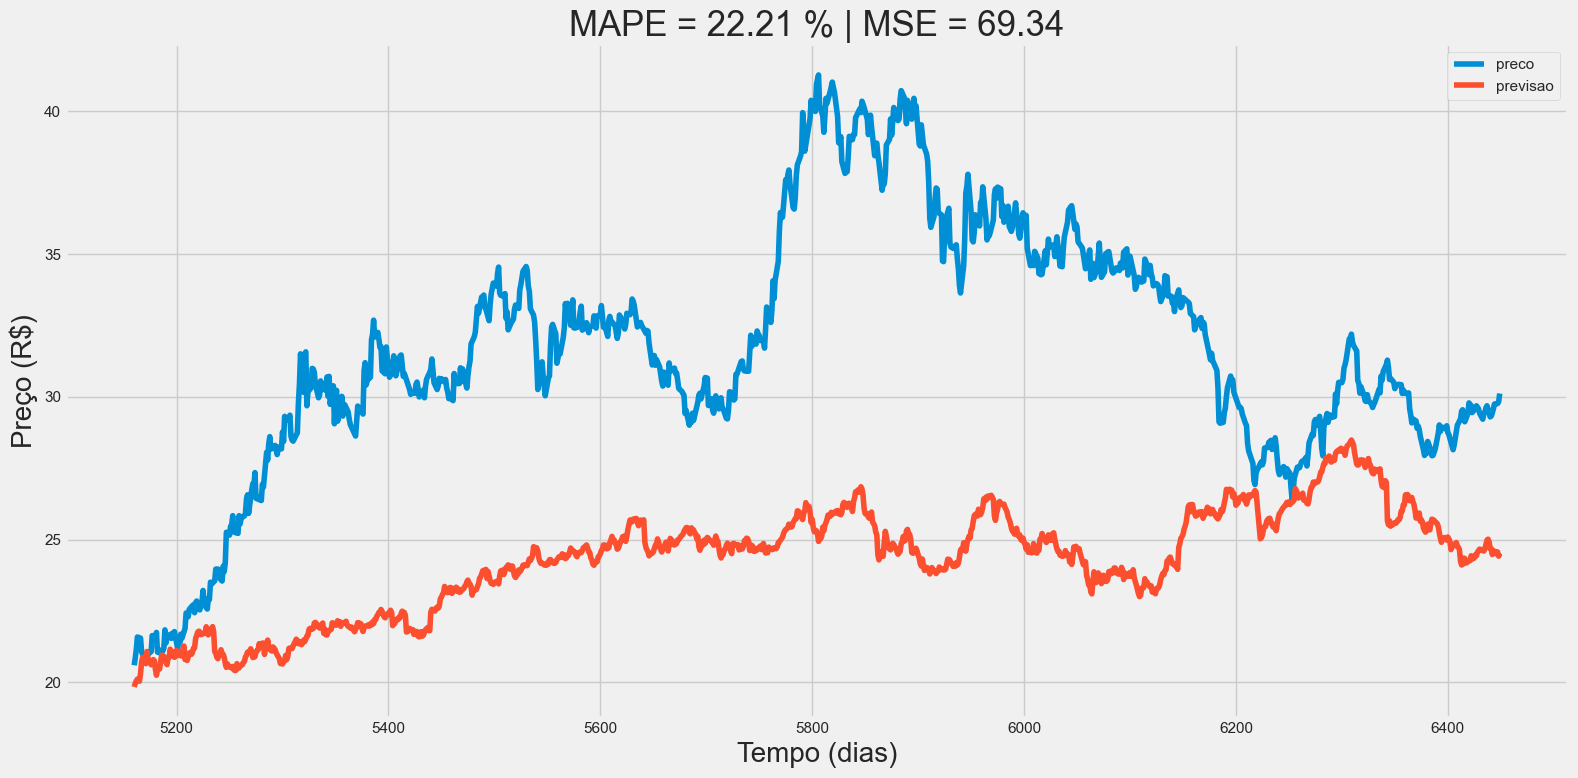

In [51]:
show_result_model(df_train=df_train,
                  df_test=df_test, 
                  y_forecast=y_ar_forecast,
                  model_name='ar_model')

<br/>

#### **ARIMA**

#### Librarie: `pmdarima`
- Tips: https://alkaline-ml.com/pmdarima/tips_and_tricks.html

In [53]:
%%time

list_order_arima = search_best_params_arima_model(df_train=df_train,
                                                  pdq=list_pdq)
print(list_order_arima)

best ARIMA: (0, 0, 0) | AIC:99999
[(0, 0, 0), 99999]
CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
%%time

autoarima_model = pm.auto_arima(df_train,
                                stepwise=True,
                                suppress_warnings=True,
                                error_action="ignore",
                                information_criterion='aic',
                                start_p=2,
                                start_d=1,
                                start_q=2,
                                lags=lags,
                                seasonal=True,
                                trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1582.199, Time=5.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1619.432, Time=1.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1587.125, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1589.787, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1617.560, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1582.183, Time=4.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1580.472, Time=1.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1581.972, Time=2.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1584.482, Time=4.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1583.551, Time=6.67 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1578.574, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1587.898, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1580.285, Time=1.98 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1580.076, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [55]:
print(autoarima_model.order)
print(autoarima_model.aic())

(0, 1, 2)
1578.573776362042


In [57]:
# fit
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [58]:
# forecast
y_forecast = autoarima_model_fit.predict(n_periods=size_test)
len(y_forecast)

1290

In [59]:
print(autoarima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5160
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -786.287
Date:                Tue, 26 Mar 2024   AIC                           1578.574
Time:                        17:02:08   BIC                           1598.219
Sample:                             0   HQIC                          1585.448
                               - 5160                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0794      0.009      8.460      0.000       0.061       0.098
ma.L2          0.0477      0.011      4.410      0.000       0.027       0.069
sigma2         0.0794      0.000    222.963      0.0

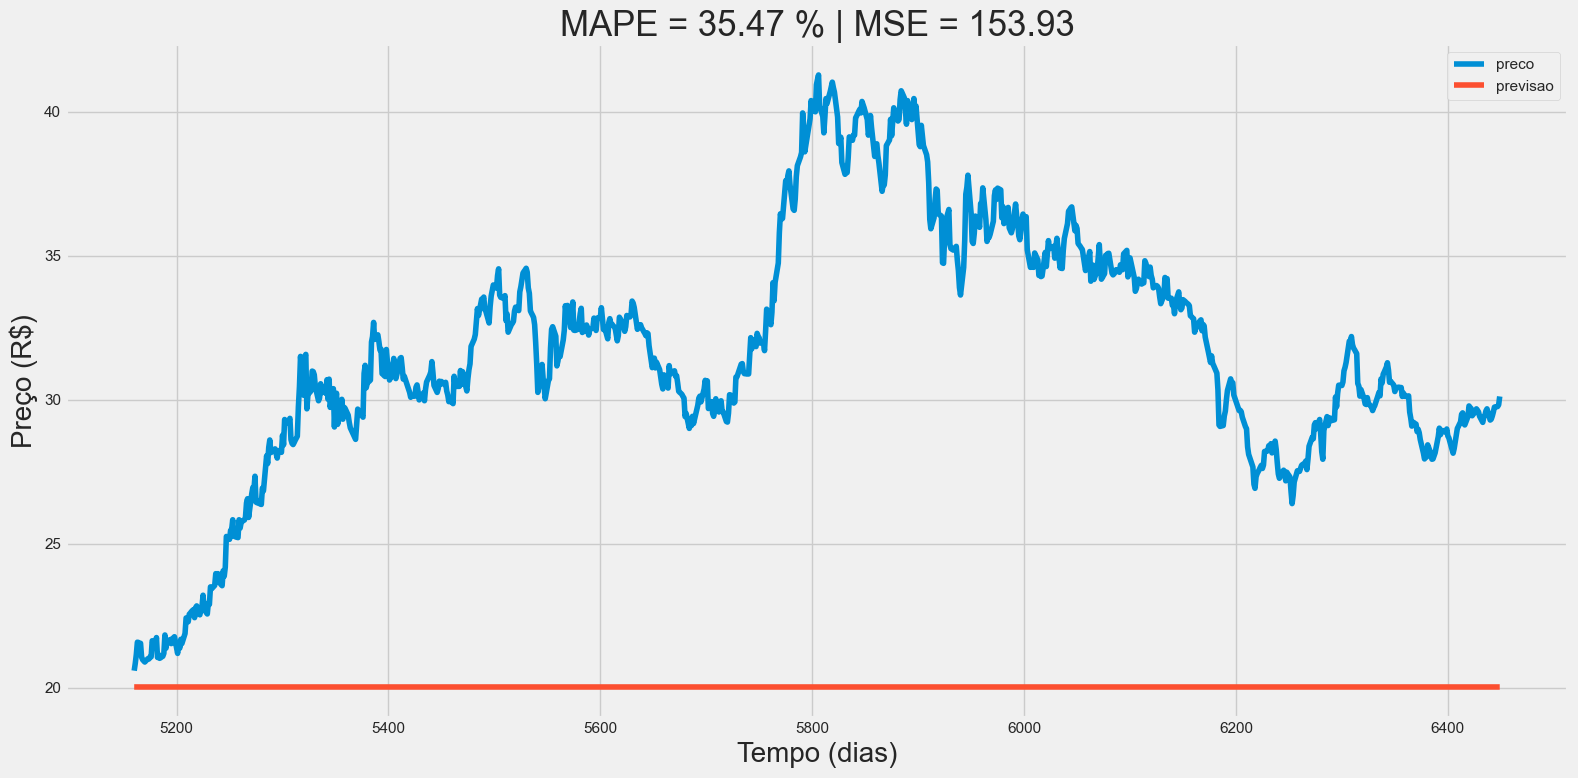

In [60]:
show_result_model(df_train=df_train,
                  df_test=df_test,
                  y_forecast=y_forecast,
                  model_name='arima_model')

O MAPE é uma medida de precisão que compara as previsões do modelo com os valores reais. Ele é calculado como a média dos erros percentuais absolutos, onde o erro percentual absoluto é a diferença absoluta entre a previsão e o valor real, dividido pelo valor real. Um MAPE menor indica que as previsões do modelo estão mais próximas dos valores reais.

O MSE é uma medida de erro que compara as previsões do modelo com os valores reais. Ele é calculado como a média dos erros quadrados, onde o erro quadrado é a diferença entre a previsão e o valor real ao quadrado. Um MSE menor indica que as previsões do modelo estão mais próximas dos valores reais.

Portanto, ao avaliar um modelo de previsão, você geralmente deseja minimizar tanto o MAPE quanto o MSE.

<br/>

#### **SARIMA**

In [68]:
%%time

list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train,
                                                          trend='t',
                                                          pdq=(2, 1, 2))
print(list_order_seasonal_aic)

pdq = (2, 1, 2) | param_seasonal = (0, 0, 0, 12) | AIC = 1582.3274976424009
pdq = (2, 1, 2) | param_seasonal = (0, 0, 1, 12) | AIC = 1584.309219782779
pdq = (2, 1, 2) | param_seasonal = (0, 0, 2, 12) | AIC = 1586.3758277420939
pdq = (2, 1, 2) | param_seasonal = (0, 1, 0, 12) | AIC = 5128.84417774076
pdq = (2, 1, 2) | param_seasonal = (0, 1, 1, 12) | AIC = 3002.474644446798
pdq = (2, 1, 2) | param_seasonal = (0, 1, 2, 12) | AIC = 2815.678127675874
pdq = (2, 1, 2) | param_seasonal = (0, 2, 0, 12) | AIC = 10761.710602264486
pdq = (2, 1, 2) | param_seasonal = (0, 2, 1, 12) | AIC = 8808.755731104184
pdq = (2, 1, 2) | param_seasonal = (0, 2, 2, 12) | AIC = 6957.226089384192
pdq = (2, 1, 2) | param_seasonal = (1, 0, 0, 12) | AIC = 1584.2669158577132
pdq = (2, 1, 2) | param_seasonal = (1, 0, 1, 12) | AIC = 1586.2982927266323
pdq = (2, 1, 2) | param_seasonal = (1, 0, 2, 12) | AIC = 1588.46901889312
pdq = (2, 1, 2) | param_seasonal = (1, 1, 0, 12) | AIC = 3870.016939433828
pdq = (2, 1, 2) | para

In [67]:
list_order_seasonal_aic

[(), 99999]

In [60]:
sarima_model = SARIMAX(df_train,
                       order=(2, 1, 2),
                       seasonal_order=list_order_seasonal_aic[0],
                       seasonal=True,
                       trend='c',          
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [61]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

In [62]:
# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1]).to_numpy()
len(y_forecast_sarima)

1290

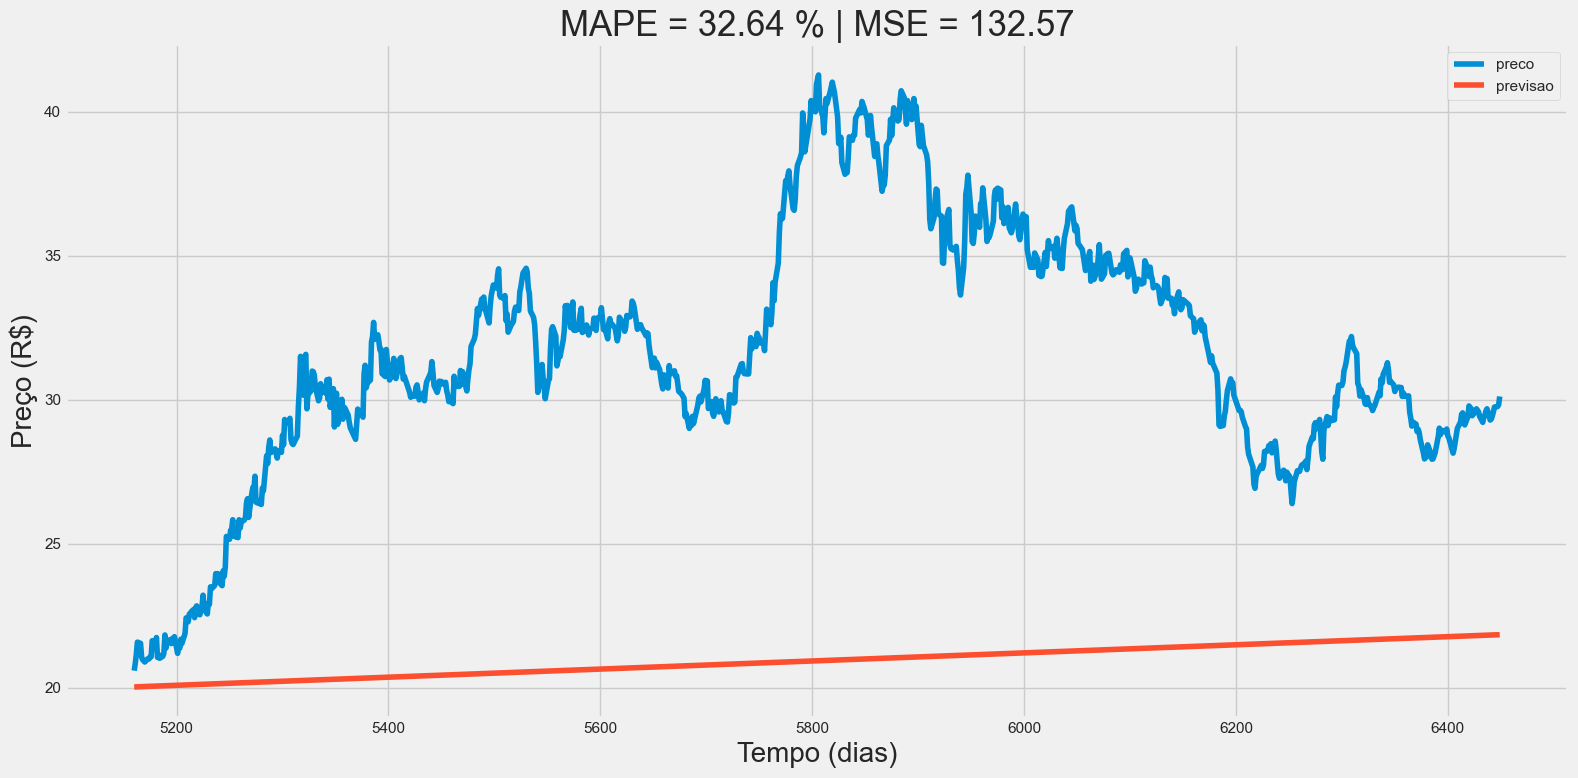

In [63]:
show_result_model(df_train=df_test,
                  df_test=df_test,
                  y_forecast=y_forecast_sarima,
                  model_name='sarima_model')

---

## **5. Results**

In [69]:
dict_results

{'ar_model': [37.809566966545646, 173.2904197296997],
 'arima_model': [35.47486827965031, 153.93007030477347],
 'sarima_model': [32.63962841502088, 132.56648089279392]}

---